<a href="https://www.kaggle.com/code/captaindeadpool53/dog-breed-classifier?scriptVersionId=168461658" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, activations,losses


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def addAugmentedData(dataset):
    augmentationLayer = Sequential([
        layers.RandomFlip(seed=1111),
        layers.RandomRotation(0.2, seed=1111),
        layers.RandomZoom(0.2, seed=1111)
    ])
    augmentedData = dataset.map(lambda x, y: (augmentationLayer(x), y))
    augmentedData = augmentedData.map(lambda img, label: (tf.image.convert_image_dtype(img, tf.uint8), label))

    completeDataset = dataset.concatenate(augmentedData)
    return completeDataset


In [4]:
def loadImagesWithClassName(csv_file_path, imagePath):
    labelsDf = pd.read_csv(csv_file_path)
    image_class_mapping = dict(zip(labelsDf['id'], labelsDf['breed']))

    file_paths = [imagePath + image_name + '.jpg' for image_name in labelsDf['id']]
    labels = [class_name for class_name in labelsDf['breed']]
    
    num_classes = len(labelsDf['breed'].unique())
    labels_one_hot = tf.one_hot(pd.Categorical(labels).codes, num_classes) #see
    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels_one_hot))
    dataset = dataset.map(load_image)
    
#     dataset = addAugmentedData(dataset)
    dataset = dataset.shuffle(buffer_size=(dataset.cardinality().numpy())/2)
    
    train_dataset = dataset.skip(int(0.2*(dataset.cardinality().numpy()))).batch(64)
    test_dataset =dataset.take(int(0.2*(dataset.cardinality().numpy()))).batch(64)

    return  train_dataset, test_dataset

def load_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_crop_or_pad(image,500,500)
    return image, label

train, test = loadImagesWithClassName('/kaggle/input/dog-breed-identification/labels.csv', '/kaggle/input/dog-breed-identification/train/')


train = train.prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.prefetch(buffer_size=tf.data.AUTOTUNE)

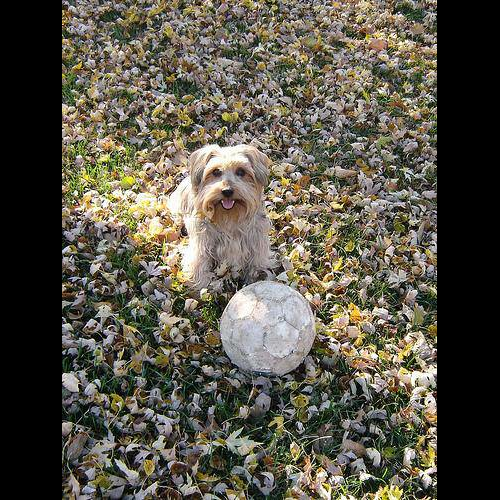

In [5]:
firstTake = train.take(4)
images, labels1 = list(firstTake)[0]

firstImage = images[0]
numpyImage = firstImage.numpy().astype("uint8")
img = Image.fromarray(numpyImage)
img


In [6]:
labels1  

<tf.Tensor: shape=(64, 120), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [7]:
def createAndTrainModel(networkArray, train, test):
        savePath = '/kaggle/working/model.h5'
        
        model = Sequential(networkArray)
        if os.path.exists(savePath):
            model.load_weights(savePath)
            print(":::Loaded saved weights:::")
        
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
        
        checkpointCallback = tf.keras.callbacks.ModelCheckpoint(
            savePath,
            monitor = 'val_loss',
            verbose = 1,
            save_best_only = True,
            save_weights_only = True,
        )
        
        history = model.fit(train, validation_data=test, epochs = 60, callbacks = [checkpointCallback])
    
        return pd.DataFrame(history.history), model

In [8]:
#AlexNet architecture
network = [
        layers.InputLayer(input_shape=( 500, 500, 3)),
        layers.Rescaling(1/255),
        layers.Conv2D(96, kernel_size=(11,11), strides= (4, 4),padding= 'valid', activation= 'relu'),
        layers.MaxPooling2D(pool_size=(3,3), strides= (2,2),padding= 'valid'),
        layers.Conv2D(256, kernel_size=(5,5), strides= (1,1),padding= 'same', activation= 'relu'),
        layers.MaxPooling2D(pool_size=(3,3), strides= (2,2), padding= 'valid'),
        layers.Conv2D(384, kernel_size=(3,3), strides= (1,1),padding= 'same', activation= 'relu'),
#         layers.Conv2D(384, kernel_size=(3,3), strides= (1,1), padding= 'same', activation= 'relu'),
#         layers.Conv2D(256, kernel_size=(3,3), strides= (1,1), padding= 'same', activation= 'relu'),
        layers.MaxPooling2D(pool_size=(3,3), strides= (2,2),padding= 'valid'),
        layers.Flatten(),
        layers.Dense(4098, activation= 'relu'),
        layers.Dense(2048, activation= 'relu'), 
        layers.Dense(1024, activation= 'relu'),
        layers.Dense(units = 120, activation = 'softmax')
]


In [9]:

history, model = createAndTrainModel(network,  train, test)

Epoch 1/60
128/128 [==============================] - ETA: 0s - loss: 5.0459 - accuracy: 0.0110
Epoch 1: val_loss improved from inf to 4.74312, saving model to /kaggle/working/model.h5
128/128 [==============================] - 55s 301ms/step - loss: 5.0459 - accuracy: 0.0110 - val_loss: 4.7431 - val_accuracy: 0.0147
Epoch 2/60
128/128 [==============================] - ETA: 0s - loss: 4.7304 - accuracy: 0.0158
Epoch 2: val_loss improved from 4.74312 to 4.69687, saving model to /kaggle/working/model.h5
128/128 [==============================] - 36s 229ms/step - loss: 4.7304 - accuracy: 0.0158 - val_loss: 4.6969 - val_accuracy: 0.0166
Epoch 3/60
128/128 [==============================] - ETA: 0s - loss: 4.6957 - accuracy: 0.0198
Epoch 3: val_loss improved from 4.69687 to 4.68525, saving model to /kaggle/working/model.h5
128/128 [==============================] - 35s 224ms/step - loss: 4.6957 - accuracy: 0.0198 - val_loss: 4.6853 - val_accuracy: 0.0186
Epoch 4/60
128/128 [===============

In [10]:
model.summary()
model.save_weights('/kaggle/working/model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 500, 500, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 123, 123, 96)      34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 61, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 384)       8

<Axes: >

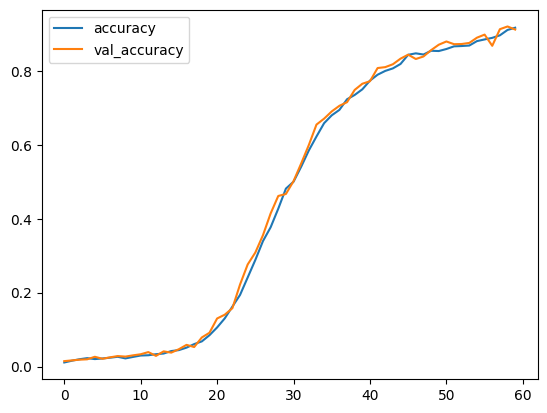

In [11]:
history[['accuracy','val_accuracy']].plot()

In [12]:
labelsDf = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
labels = [class_name for class_name in labelsDf['breed']]

breeds = pd.Categorical(labels).categories
breeds

Index(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller', 'australian_terrier',
       'basenji', 'basset', 'beagle',
       ...
       'toy_poodle', 'toy_terrier', 'vizsla', 'walker_hound', 'weimaraner',
       'welsh_springer_spaniel', 'west_highland_white_terrier', 'whippet',
       'wire-haired_fox_terrier', 'yorkshire_terrier'],
      dtype='object', length=120)

In [13]:

# print("Example"+ "     |     "+ "Label"+"     |     "+"Prediction"+ "\n")

# for images, labels in test:
    
#     predictions = model.predict(images)
#     predictions = predictions.argmax(axis=1)
#     predictions = [breeds[i] for i in predictions]
#     labels = [breeds[i] for i in np.array(labels).argmax(axis=1)]
#     for i in range(10):
#         # Get the image and label
#         image = images[i]
#         label = labels[i]
        
#         # Convert the image tensor to a NumPy array
#         image_np = image.numpy().astype("uint8")
#         im=plt.imshow(image_np) 
#         plt.axis('off')
        
#         plt.show()
#         print(str(i+1) + "     |     "+label+"     |     "+predictions[i]+ "\n" )

In [14]:
def load_prediction_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_crop_or_pad(image,500,500)
    return image

In [15]:
filenameList = []
for root, folders, files in os.walk('/kaggle/input/dog-breed-identification/test/'):
    for file in files:
        filenameList.append(os.path.join(root, file))
        
predictionDataset = tf.data.Dataset.from_tensor_slices(filenameList)
predictionDataset = predictionDataset.map(load_prediction_image).batch(64)

In [16]:
predictionResult = model.predict(predictionDataset)

dataframe1 = pd.DataFrame({"id": filenameList})
dataframe2 = pd.DataFrame(predictionResult, columns = [breeds])



162/162 [==============================] - 30s 184ms/step


TypeError: concat() takes 1 positional argument but 2 were given

In [20]:
finalPredictionDataFrame = pd.concat([dataframe1,dataframe2])
finalPredictionDataFrame.to_csv('/kaggle/working/submission.csv', index=False)